# Clothing Segmentation Model using U-Net

### 1. Import the Libraries

In [1]:
# Importing the libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np

from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


### 2. Load the Data

#### 2.1 Create DataLoader Class

In [2]:
# Class to load the dataset, convert the images and masks to tensors, 
# normalize the images, resize the images and masks, and split the dataset 
# into train and validation
class DatasetLoader():
    def __init__(self):
      pass

    '''
      Load images and masks from the dataset

      @param images_path - path to the images
      @param masks_path - path to the masks
      @return train_dataset - train dataset
      @return validation_dataset - validation dataset
    '''
    def load_images_and_masks(self, images_path, masks_path):
      image_paths = []
      mask_paths = []

      # Put the images paths into a list
      for root, dir, files in os.walk(images_path):
        for file in files:
          path = os.path.join(root, file)
          image_paths.append(path)

      # Put the masks paths into a list
      for root, dir, files in os.walk(masks_path):
        for file in files:
          path = os.path.join(root, file)
          mask_paths.append(path)

      # Sort the lists into their correct orders
      image_paths.sort()
      mask_paths.sort()

      # Convert images and masks to tensors
      images, masks = self._convert_images_masks_to_tensors(image_paths, mask_paths)

      # Normalize images
      images = self._normalize_images(images)

      # Resize images and masks
      images, masks = self._resize_images_and_masks(images, masks)

      # Split dataset into train and validation
      train_dataset, validation_dataset = self._train_test_split_dataset(images, masks)

      return train_dataset, validation_dataset

    '''
      Convert images and masks to tensors

      @param image_paths - list of image paths
      @param mask_paths - list of mask paths
      @return images - list of images
      @return masks - list of masks
    '''
    def _convert_images_masks_to_tensors(self, image_paths, mask_paths):
      images = []
      masks = []

      # Convert images to tensors
      for image in image_paths:
        image = tf.io.read_file(image)
        image = tf.image.decode_png(image, channels=3, dtype=tf.uint8)
        images.append(image)

      # Convert masks to tensors
      for mask in mask_paths:
        mask = tf.io.read_file(mask)
        mask = tf.image.decode_png(mask, channels=1, dtype=tf.uint8)
        masks.append(mask)

      return images, masks

    '''
      Split dataset into train and validation

      @param images - list of images
      @param masks - list of masks
      @return train_dataset - train dataset
      @return validation_dataset - validation dataset
    '''
    def _train_test_split_dataset(self, images, masks):
      train_X, validation_X, train_y, validation_y = train_test_split(images, masks, test_size=0.2, random_state=42)

      # Convert train and validation datasets to tensors
      train_X = tf.data.Dataset.from_tensor_slices(train_X)
      train_y = tf.data.Dataset.from_tensor_slices(train_y)

      # Convert the validation datasets to tensors
      validation_X = tf.data.Dataset.from_tensor_slices(validation_X)
      validation_y = tf.data.Dataset.from_tensor_slices(validation_y)

      # create a 1-1 mapping from X -> y
      train_dataset = tf.data.Dataset.zip(train_X, train_y)
      validation_dataset = tf.data.Dataset.zip(validation_X, validation_y)

      return train_dataset, validation_dataset

    '''
      Normalize input images

      @param images - list of images
      @return image_list - list of normalized images
    '''
    def _normalize_images(self, images):
      image_list = []
      for image in images:
        image = tf.cast(image, tf.float32)
        image = image / 255.0
        image_list.append(image)

      return image_list

    '''
      Resize images and masks

      @param images - list of images
      @param masks - list of masks
      @return image_list - list of resized images
      @return mask_list - list of resized masks
    '''
    def _resize_images_and_masks(self, images, masks):
      image_list = []
      mask_list = []

      for image in images:
        image = tf.image.resize(image, (128, 128))
        image_list.append(image)

      for mask in masks:
        mask = tf.cast(mask, tf.uint8)
        mask = tf.image.resize(mask, (128, 128),
                                      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        mask_list.append(mask)

      return image_list, mask_list

#### 2.2 Load, Normalize and Resize image and masks

In [3]:
# Define dataset paths
TRAIN_DATASET_PATH = "Resources/images"
VALIDATION_DATASET_PATH = "Resources/masks"

In [4]:
# Create a DatasetLoader object
dataset_loader = DatasetLoader()

In [5]:
# Load the data set, convert the images and masks to tensors, normalize the images,
# resize the images and masks, and split the dataset into train and validation
train_dataset, validation_dataset = dataset_loader\
    .load_images_and_masks(TRAIN_DATASET_PATH, VALIDATION_DATASET_PATH)

### 3. Verify the loaded data and masks

#### 3.1 Create ImageViewer Class

In [6]:
# Class to vie the images and masks
class ImageViewer():
    def __init__(self):
      pass

    '''
      Show images and masks from a dataset

      @param dataset - dataset to containg images and masks to display
      @param num_to_show - an even number of images to show (default is 2)
    '''
    def show_from_dataset(self, dataset, num_to_show=2):
      plt.figure(figsize=(15,15))

      for image, mask in dataset.take(1):
        for i in range(num_to_show):
          if (i % 2) == 0:
            plt.subplot(1,2,i+1)
            plt.imshow(image)
            plt.axis('off')
          else:
            plt.subplot(1,2,i+1)
            plt.imshow(mask)
            plt.axis("off")
            plt.show()

    '''
      Plot two images side-by-side
      @param image1 -image 1
      @param image2 - image 2
    '''
    def plot_two_images(self, image1, image2):
      plt.figure(figsize=(15,15))
      plt.subplot(1,2, 1)
      plt.imshow(image1)
      plt.axis('off')

      plt.subplot(1,2, 2)
      plt.imshow(image2)
      plt.axis("off")
      plt.show()

    '''
      Show prediction

      @param image - image
      @param mask - mask
      @param pred - prediction
    '''
    def show_pred(self, image, mask, pred):
        plt.figure(figsize=(20,28))

        k = 0
        for i in pred:
            # show the predicted mask
            plt.subplot(4,3,1+k*3)
            i = tf.argmax(i, axis=-1)
            plt.imshow(i)
            plt.axis('off')
            plt.title('Prediction')

            # show the groundtruth mask
            plt.subplot(4,3,2+k*3)
            plt.imshow(mask[k])
            plt.axis('off')
            plt.title('Ground Truth')

            # show the real image
            plt.subplot(4,3,3+k*3)
            plt.imshow(image[k])
            plt.axis('off')
            plt.title('Actual')
            k += 1
            if k == 4: break

        plt.suptitle('Preditions', color='blue', size=24)
        plt.show()

#### 3.2 View Image and correspoding mask

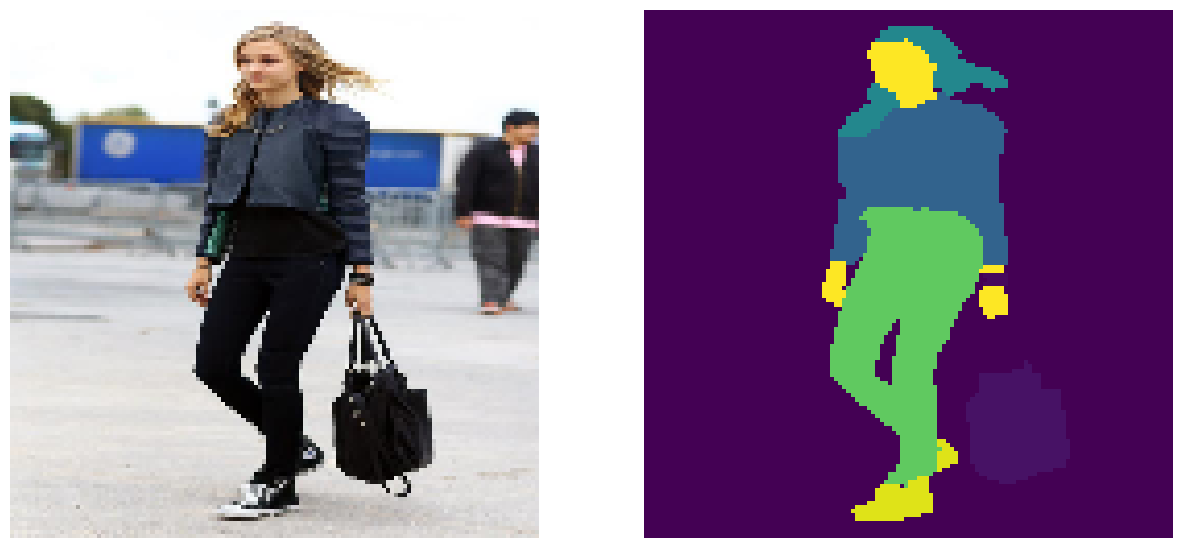

2024-08-18 08:50:40.641271: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# Create an image viewer object
image_viewer = ImageViewer()
# View the images and masks from the train_dataset
image_viewer.show_from_dataset(train_dataset)

### 4. Augment the Images and Masks

#### 4.1 Create an AugmentDataset Class

In [8]:
class AugmentDataset():
    def __init__(self):
      pass

    '''
      Augment dataset

      @param image_dataset - image dataset
      @return image_dataset - augmented image dataset
    '''
    def augment_dataset(self, image_dataset):
      a = image_dataset.map(self._brightness)
      b = image_dataset.map(self._contrast)
      c = image_dataset.map(self._saturation)
      d = image_dataset.map(self._hue)
      e = image_dataset.map(self._crop)
      f = image_dataset.map(self._flip)
      g = image_dataset.map(self._rotate)
      h = image_dataset.map(self._rotate270)
      i = image_dataset.map(self._flip_up_down)
      j = image_dataset.map(self._gamma)

      # Concatenate all augmented datasets to return a dataset 7X larger
      image_dataset = image_dataset.concatenate(a)
      image_dataset = image_dataset.concatenate(b)
      image_dataset = image_dataset.concatenate(c)
      image_dataset = image_dataset.concatenate(d)
      image_dataset = image_dataset.concatenate(e)
      image_dataset = image_dataset.concatenate(f)
      image_dataset = image_dataset.concatenate(g)
      image_dataset = image_dataset.concatenate(h)
      image_dataset = image_dataset.concatenate(i)
      image_dataset = image_dataset.concatenate(j)

      return image_dataset

    '''
      Adjust an image's brightness

      @param image - image
      @return bright adjusted image
    '''
    def _brightness(self, image, mask):
        image = tf.image.adjust_brightness(image, 0.1)
        return image, mask

    '''
      Adjust an image and mask's contrast

      @param image - image
      @param mask - mask
      @return contrast adjusted image
      @return contrast adjusted mask
    '''
    def _contrast(self, image, mask):
        image = tf.image.adjust_contrast(image, 0.1)
        return image, mask

    '''
      Adjust an image and mask's saturation

      @param image - image
      @param mask - mask
      @return saturation adjusted image
      @return saturation adjusted mask
    '''
    def _saturation(self, image, mask):
        image = tf.image.adjust_saturation(image, 0.1)
        return image, mask

    '''
      Adjust an image and mask's hue

      @param image - image
      @param mask - mask
      @return hue adjusted image
      @return hue adjusted mask
    '''
    def _hue(self, image, mask):
        image = tf.image.adjust_hue(image, 0.1)
        return image, mask

    '''
      Crop an image and mask

      @param image - image
      @param mask - mask
      @return cropped image
      @return cropped mask
    '''
    def _crop(self, image, mask):
      tf.image.central_crop(image, 0.7)
      tf.image.resize(image, (128, 128))

      mask = tf.image.central_crop(mask, 0.7)
      mask = tf.image.resize(mask, (128,128))
      mask = tf.cast(mask, tf.uint8)

      return image, mask

    '''
      Flip an image and mask

      @param image - image
      @param mask - mask
      @return flipped image
      @return flipped mask
    '''
    def _flip(self, image, mask):
      image = tf.image.flip_left_right(image)
      mask = tf.image.flip_left_right(mask)
      return image, mask

    '''
      Rotate an image and mask 90 degress

      @param image - image
      @param mask - mask
      @return rotated image
      @return rotated mask
    '''
    def _rotate(self, image, mask):
      image = tf.image.rot90(image)
      mask = tf.image.rot90(mask)
      return image, mask
    
    '''
      Rotate an image and mask 270 degrees

      @param image - image
      @param mask - mask
      @return rotated image
      @return rotated mask
    '''
    def _rotate270(self, image, mask):
      image = tf.image.rot90(image, -1)
      mask = tf.image.rot90(mask, -1)
      return image, mask
    
    '''
      Flip an image and mask upside down

      @param image - image
      @param mask - mask
      @return flipped image
      @return flipped mask
    '''
    def _flip_up_down(self, image, mask):
      image = tf.image.flip_up_down(image)
      mask = tf.image.flip_up_down(mask)
      return image, mask
    
    '''
      Adjust an image and mask's gamma

      @param image - image
      @param mask - mask
      @return gamma adjusted image
      @return gamma adjusted mask
    '''
    def _gamma(self, image, mask):
        image = tf.image.adjust_gamma(image, 0.1)
        return image, mask

#### 4.2 Augment the images and masks

In [9]:
# Create an AugmentDataset object
augment_dataset = AugmentDataset()
# Augment the train_dataset
train_dataset = augment_dataset.augment_dataset(train_dataset)

In [10]:
# Print the length of the train_dataset after augmentation
print("Training Dataset: ", len(train_dataset))


Training Dataset:  8800


In [11]:
# Print the element spec of the train_dataset to check if the augmentation was successful
print("Training Dataset #:", train_dataset.element_spec)

Training Dataset #: (TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))


### 5. U-Net Model

#### 5.1 Define Model Parameters

In [12]:
# Model Parameters
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000

STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH
INITIAL_EPOCHS = 50
FINE_TUNE_EPOCHS = 150

#### 5.2 Create Model Builder Class

In [13]:
# Model Builder Class
class ModelBuilder():
    def __init__(self):
      self.down_sampling_model = None
      self.unet_model = None

    '''
      Create a unet model

      @return unet model
    '''
    def build_unet_model(self):
      # create the upsampling model using a combination of upsampling models
      upsampling_model = [
          self.build_upsampling_model(512, 4),
          self.build_upsampling_model(256, 4),
          self.build_upsampling_model(128, 4),
          self.build_upsampling_model(64, 4)
      ]

      # create the input layer using the shape of the images
      inputs = tf.keras.layers.Input(shape=[128, 128, 3])

      self.down_sampling_model = self.build_down_sampling_model()

      # store the results of the inputs going through the downsampling model
      down_sample = self.down_sampling_model(inputs)

      # store the last layer result as an output
      output = down_sample[-1]

      # store every output from the downsampling layer except the last one
      skips = reversed(down_sample[:-1])

      # loop through the upsampling model and the skips and concatenate them
      for upsample, skip in zip(upsampling_model, skips):
        output = upsample(output)
        output = tf.keras.layers.Concatenate()([output, skip])

      # downsample the output to get 59 mask potential values
      output = tf.keras.layers.Conv2DTranspose(
          filters=59,
          kernel_size=3,
          strides=2,
          padding='same')(output)

      # create and compile the UNET model
      self.unet_model = tf.keras.Model(inputs=inputs, outputs=output)
      self.compile_unet_model()

      return self.unet_model

    '''
      Compile a unet model
    '''
    def compile_unet_model(self):
      self.unet_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        metrics=['accuracy'])

    '''
      Create a fine-tuned unet model

      @return fine-tuned unet model
    '''
    def build_fine_tuned_unet_model(self):
      # enable training for the down_sampling_model (MobileNetV2)
      self.down_sampling_model.trainable = True

      # recompile the model
      self.compile_unet_model()

      return self.unet_model

    '''
      Create a down-sampling model

      @return down-sampling model
    '''
    def build_down_sampling_model(self):
      # using MobileNetV2 but any other choice could probably work here
      base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

      # Looking through the MobileNetV2 plot_model I found these blocks that
      # fit the needs of the down_sampling_model.
      skip_layer_names = [
          "block_1_expand_relu", # 128 -> 64
          "block_2_expand_relu", # 64 -> 32
          "block_5_expand_relu", # 32 -> 16
          "block_8_expand_relu", # 16 -> 8
          "block_14_expand_relu", # 8 -> 4
      ]

      # get the skip layers from the base model using the layer names
      skip_layers = [base_model.get_layer(name).output for name in skip_layer_names]

      # create the down_sampling model with the base model having training disabled
      down_stack = tf.keras.Model(inputs=base_model.input, outputs=skip_layers)
      down_stack.trainable = False

      return down_stack

    '''
      Create an up-sampling model

      @param filters - number of filters
      @param size - size of the kernel
      @return up-sampling model
    '''
    def build_upsampling_model(self, filters, size):
      initializer = tf.random_normal_initializer(0., 0.02)

      upsampling_model = tf.keras.Sequential()
      upsampling_model.add(tf.keras.layers.Conv2DTranspose(
          filters, size, strides=2,
          padding='same',
          kernel_initializer=initializer,
          use_bias=False))

      upsampling_model.add(tf.keras.layers.BatchNormalization())
      upsampling_model.add(tf.keras.layers.ReLU())

      return upsampling_model

### 5.3 Build the U-Net Model

In [14]:
# Create a ModelBuilder object
model_builder = ModelBuilder()
# Build a U-Net model
unet_model = model_builder.build_unet_model()
# Print the summary of the U-Net model
unet_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 64, 64,   │    873,984 │ input_layer[0][0] │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 384), (None, 4,   │            │                   │
│                     │ 4, 960)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 512) │  7,866,368 │ functional[0][4]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 896) │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 16, 16,    │  3,671,040 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    918,016 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    278,784 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │     85,019 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 59)               │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,693,211 (52.24 MB)

 Trainable params: 12,817,307 (48.89 MB)

 Non-trainable params: 875,904 (3.34 MB)

In [15]:
# Cache the dataset in memory, shuffle the dataset, batch the dataset into mini-batches and
# repeat the dataset (this is used to ensure that the model sees the entire dataset)
train_dataset = train_dataset.cache().shuffle(BUFFER).batch(BATCH).repeat()

In [16]:
# Prefetch - creates a background thread that preloads data while the model is training
train_dataset = train_dataset.prefetch(buffer_size=AT)

In [17]:
# Batch the validation dataset - This function splits the validation dataset 
# into mini-batches of size BATCH.
validation_dataset = validation_dataset.batch(BATCH)

2024-08-18 08:50:41.996500: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


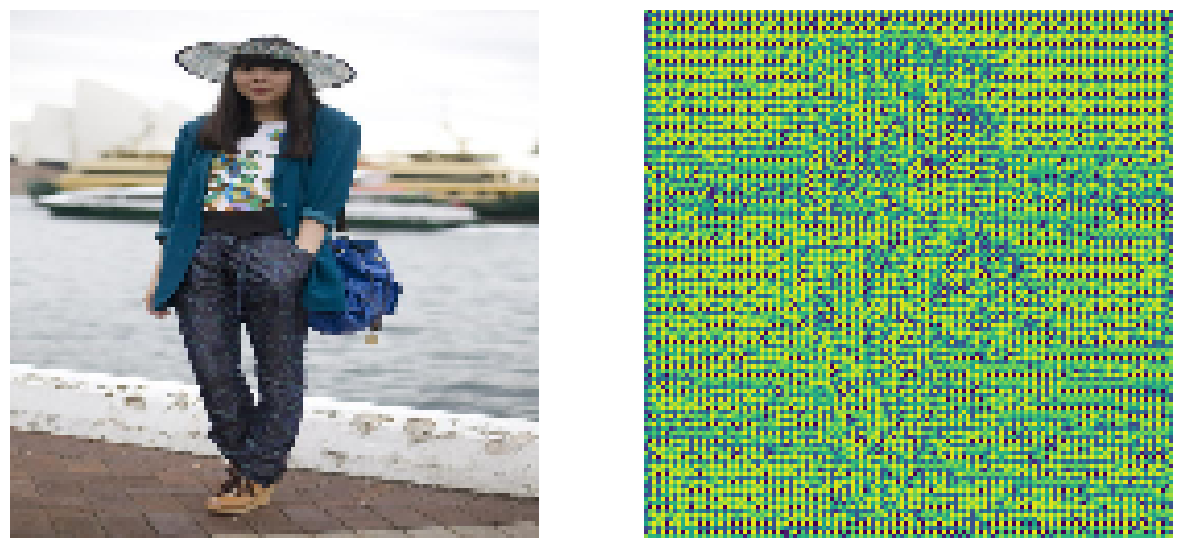

In [18]:
# Infer on train dataset
example = next(iter(train_dataset))
preds = unet_model(example[0])
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)

pred_mask = pred_mask[0]
actual_image = example[0][0]

image_viewer.plot_two_images(actual_image, pred_mask)

#### 5.4 Train/Fit the model

In [19]:
# Train the model
history = unet_model.fit(
    train_dataset,
    epochs=INITIAL_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=validation_dataset
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4779 - loss: 2.6201 - val_accuracy: 0.7677 - val_loss: 1.3164
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7678 - loss: 1.1596 - val_accuracy: 0.7556 - val_loss: 1.1914
Epoch 3/50


2024-08-18 08:51:18.007731: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/jaidevkler/anaconda3/envs/dev2/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7721 - loss: 0.9669 - val_accuracy: 0.6880 - val_loss: 1.4484
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7742 - loss: 0.8951 - val_accuracy: 0.7126 - val_loss: 1.2070
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7319 - loss: 1.1494 - val_accuracy: 0.4178 - val_loss: 2.5813
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.6965 - loss: 1.3059 - val_accuracy: 0.7176 - val_loss: 1.1277
Epoch 7/50


2024-08-18 08:52:36.035922: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.7433 - loss: 1.0775 - val_accuracy: 0.7396 - val_loss: 1.1090
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.7705 - loss: 0.9403 - val_accuracy: 0.7905 - val_loss: 0.8329
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 265s 23s/step - accuracy: 0.7884 - loss: 0.8461 - val_accuracy: 0.7856 - val_loss: 0.8534
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7918 - loss: 0.8176 - val_accuracy: 0.7255 - val_loss: 1.1044
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7896 - loss: 0.8197 - val_accuracy: 0.7849 - val_loss: 0.8718
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7967 - loss: 0.7748 - val_accuracy: 0.7461 - val_loss: 0.9520
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8034 - loss: 0.7566 - val_accuracy: 0.6799 - val_loss: 1.5576
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7972 - loss: 0.7916 - val_accuracy: 0.7784 - val_loss: 0.8

2024-08-18 08:59:59.866606: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8000 - loss: 0.7482 - val_accuracy: 0.8052 - val_loss: 0.7274
Epoch 16/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8015 - loss: 0.7564 - val_accuracy: 0.7858 - val_loss: 0.7972
Epoch 17/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7072 - loss: 1.2521 - val_accuracy: 0.7509 - val_loss: 1.0101
Epoch 18/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7588 - loss: 1.0229 - val_accuracy: 0.8228 - val_loss: 0.6810
Epoch 19/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7784 - loss: 0.9056 - val_accuracy: 0.8107 - val_loss: 0.7036
Epoch 20/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8014 - loss: 0.7773 - val_accuracy: 0.8224 - val_loss: 0.6547
Epoch 21/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8100 - loss: 0.7290 - val_accuracy: 0.8102 - val_loss: 0.6990
Epoch 22/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8046 - loss: 0.7397 - val_accuracy: 0.8368 - val_loss: 0.6

2024-08-18 09:04:02.897928: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8120 - loss: 0.7170 - val_accuracy: 0.8228 - val_loss: 0.6662
Epoch 32/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8157 - loss: 0.6872 - val_accuracy: 0.8424 - val_loss: 0.5826
Epoch 33/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8201 - loss: 0.6656 - val_accuracy: 0.8153 - val_loss: 0.6926
Epoch 34/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.8222 - loss: 0.6551 - val_accuracy: 0.8421 - val_loss: 0.5918
Epoch 35/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8298 - loss: 0.6192 - val_accuracy: 0.8308 - val_loss: 0.6201
Epoch 36/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8432 - loss: 0.5575 - val_accuracy: 0.8445 - val_loss: 0.5834
Epoch 37/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8126 - loss: 0.6956 - val_accuracy: 0.8370 - val_loss: 0.5793
Epoch 38/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8368 - loss: 0.5785 - val_accuracy: 0.8563 - val_loss: 0.5

#### 5.5 Check the prediction

In [20]:
# Use the model to make a prediction
image, mask = next(iter(validation_dataset))
pred = unet_model.predict(image)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


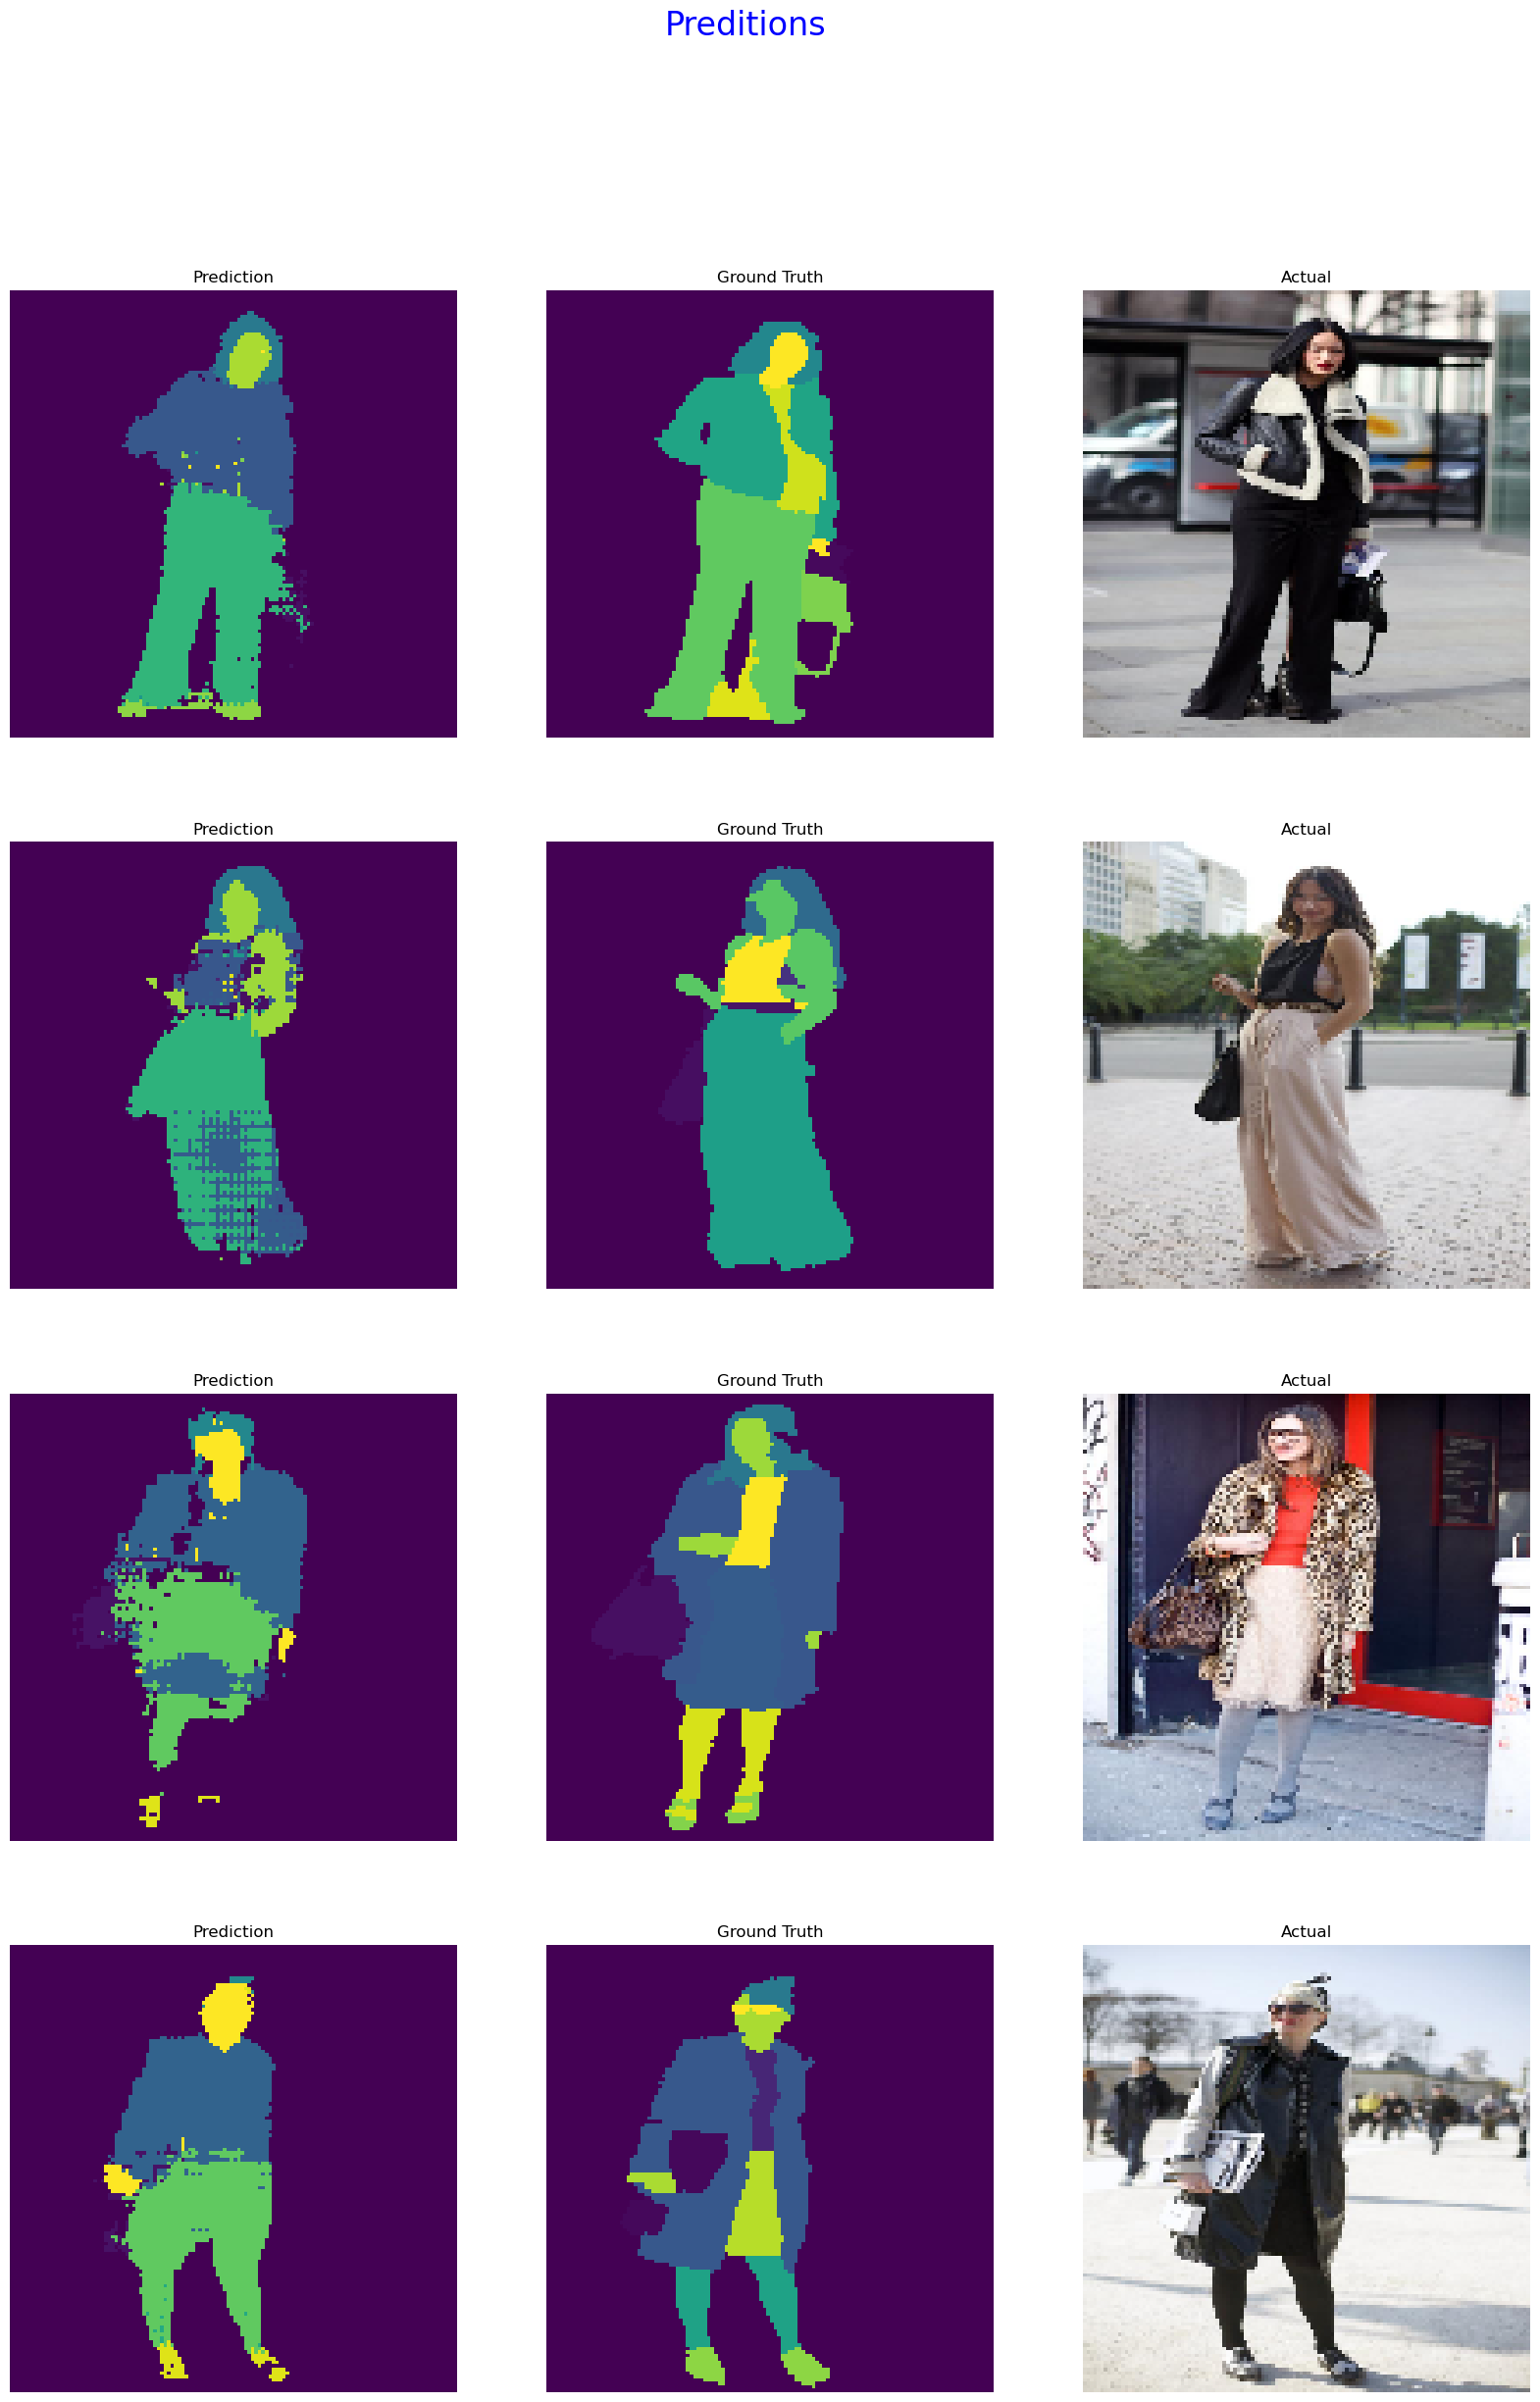

In [21]:
# View the image, mask, and prediction
image_viewer.show_pred(image, mask, pred)

#### 5.5 Model Performance

In [22]:
class PerformanceReport():
    def __init__(self):
      self.conf_matrix = None

    '''
      Plot the UNET model's loss performance

      @param model_history - the unet model history
    '''
    def plot_loss_performance_charts(self, model_history):
      loss = model_history.history['loss']
      val_loss = model_history.history['val_loss']

      plt.figure()
      plt.plot(model_history.epoch, loss, 'r', label='Training loss')
      plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss Value')
      plt.ylim([0.5, 1])
      plt.legend()
      plt.show()

    '''
      Plot the UNET model's accuracy performance

      @param model_history - the unet model history
    '''
    def plot_accuracy_performance_charts(self, model_history):
      loss = model_history.history['accuracy']
      val_loss = model_history.history['val_accuracy']

      plt.figure()
      plt.plot(model_history.epoch, loss, 'r', label='Training Accuracy')
      plt.plot(model_history.epoch, val_loss, 'bo', label='Validation Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy Value')
      plt.ylim([0.5, 1])
      plt.legend()
      plt.show()

    '''
      Display a confusion matrix

      @param y_true - true labels
      @param y_pred - predicted labels
    '''
    def display_confusion_matrix(self, y_true, y_pred):
      self.conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

      # plot the confusion matrix
      fig, ax = plt.subplots(figsize=(7.5, 7.5))
      ax.matshow(self.conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
      for i in range(self.conf_matrix.shape[0]):
          for j in range(self.conf_matrix.shape[1]):
              ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')

      plt.xlabel('Predictions', fontsize=14)
      plt.ylabel('Actuals', fontsize=14)
      plt.title('Confusion Matrix', fontsize=18)
      plt.show()

      # Show the confusion matrix results in a text report
      self._show_confusion_matrix_report()

      '''
        Display the results of the confusion matrix as a text report
      '''
      def _show_confusion_matrix_report(self):
        tn, fp, fn, tp = self.conf_matrix.ravel()

        print("True Positive (TP): ", tp)
        print("True Negative (TN): ", tn)
        print("False Positive (FP): ", fp)
        print("False Negative (FN): ", fn)

        accuracy = (tp + tn) / (tp + tn + fp + fn)

        precision = tp / (tp + fp)

        recall = tp / (tp + fn)

        f1_score = 2 * (precision * recall) / (precision + recall)

        print("\n\nMetrics:")
        print("Accuracy: ", round(accuracy, 2))
        print("Precision: ", round(precision, 2))
        print("Recall: ", round(recall, 2))
        print("F1-score: ", round(f1_score, 2))

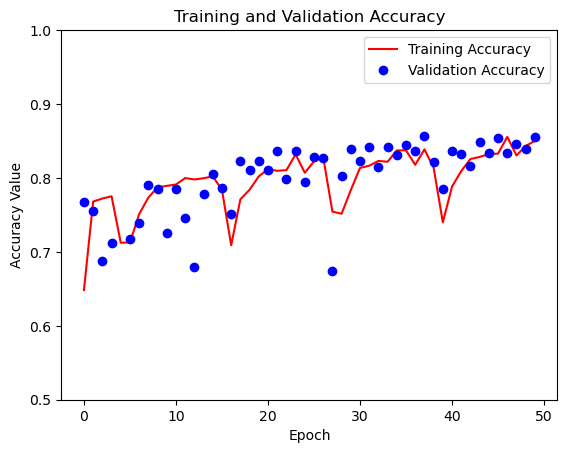

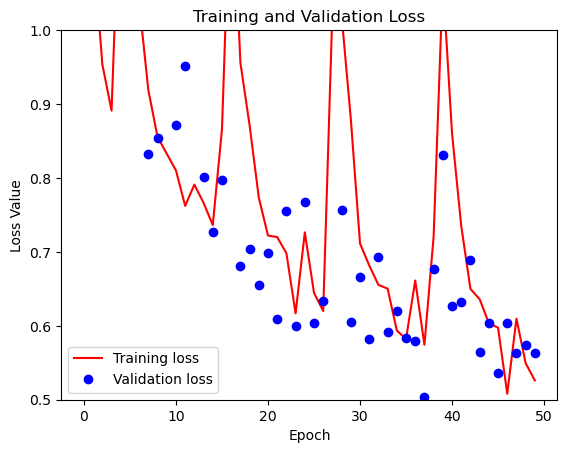

In [23]:
performance_report = PerformanceReport()

performance_report.plot_accuracy_performance_charts(history)
performance_report.plot_loss_performance_charts(history)

In [24]:
print("Accuracy: ", history.history['accuracy'][-1])
print("Loss: ", history.history['loss'][-1])

Accuracy:  0.8501353859901428
Loss:  0.5260552763938904


#### 5.6 Tuning the Model

In [25]:
unet_model = model_builder.build_fine_tuned_unet_model()

history_1 = unet_model.fit(train_dataset,
               validation_data=validation_dataset,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=150,
               initial_epoch=50,
               verbose=2)

Epoch 51/150
12/12 - 26s - 2s/step - accuracy: 0.8481 - loss: 0.5409 - val_accuracy: 0.8100 - val_loss: 0.7109
Epoch 52/150
12/12 - 19s - 2s/step - accuracy: 0.8588 - loss: 0.4985 - val_accuracy: 0.8337 - val_loss: 0.6067
Epoch 53/150
12/12 - 21s - 2s/step - accuracy: 0.8615 - loss: 0.4779 - val_accuracy: 0.8460 - val_loss: 0.5526
Epoch 54/150
12/12 - 19s - 2s/step - accuracy: 0.8678 - loss: 0.4623 - val_accuracy: 0.8486 - val_loss: 0.5731
Epoch 55/150
12/12 - 20s - 2s/step - accuracy: 0.7907 - loss: 0.8648 - val_accuracy: 0.6964 - val_loss: 1.1657
Epoch 56/150
12/12 - 19s - 2s/step - accuracy: 0.7813 - loss: 0.8742 - val_accuracy: 0.7960 - val_loss: 0.7717
Epoch 57/150
12/12 - 20s - 2s/step - accuracy: 0.8167 - loss: 0.7260 - val_accuracy: 0.7798 - val_loss: 0.8651
Epoch 58/150
12/12 - 19s - 2s/step - accuracy: 0.8342 - loss: 0.6193 - val_accuracy: 0.8146 - val_loss: 0.8140
Epoch 59/150
12/12 - 20s - 2s/step - accuracy: 0.8426 - loss: 0.5735 - val_accuracy: 0.8120 - val_loss: 0.7982
E

2024-08-18 09:13:58.291125: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 - 21s - 2s/step - accuracy: 0.8864 - loss: 0.3864 - val_accuracy: 0.8333 - val_loss: 0.6125
Epoch 64/150
12/12 - 19s - 2s/step - accuracy: 0.8902 - loss: 0.3750 - val_accuracy: 0.8560 - val_loss: 0.5584
Epoch 65/150
12/12 - 21s - 2s/step - accuracy: 0.8919 - loss: 0.3704 - val_accuracy: 0.8494 - val_loss: 0.5496
Epoch 66/150
12/12 - 18s - 2s/step - accuracy: 0.8653 - loss: 0.5216 - val_accuracy: 0.8069 - val_loss: 0.7805
Epoch 67/150
12/12 - 21s - 2s/step - accuracy: 0.7928 - loss: 0.8509 - val_accuracy: 0.8277 - val_loss: 0.6562
Epoch 68/150
12/12 - 19s - 2s/step - accuracy: 0.8255 - loss: 0.6945 - val_accuracy: 0.8178 - val_loss: 0.7076
Epoch 69/150
12/12 - 21s - 2s/step - accuracy: 0.8444 - loss: 0.5842 - val_accuracy: 0.7981 - val_loss: 0.9908
Epoch 70/150
12/12 - 21s - 2s/step - accuracy: 0.8556 - loss: 0.5259 - val_accuracy: 0.8140 - val_loss: 0.7427
Epoch 71/150
12/12 - 23s - 2s/step - accuracy: 0.8649 - loss: 0.4821 - val_accuracy: 0.8257 - val_loss: 0.7041
Epoch 72/150
1

2024-08-18 11:26:47.575042: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


12/12 - 20s - 2s/step - accuracy: 0.8943 - loss: 0.3731 - val_accuracy: 0.8032 - val_loss: 0.8645
Epoch 128/150
12/12 - 33s - 3s/step - accuracy: 0.9043 - loss: 0.3381 - val_accuracy: 0.7853 - val_loss: 0.8992
Epoch 129/150
12/12 - 20s - 2s/step - accuracy: 0.9125 - loss: 0.3012 - val_accuracy: 0.8286 - val_loss: 0.8141
Epoch 130/150
12/12 - 235s - 20s/step - accuracy: 0.9256 - loss: 0.2544 - val_accuracy: 0.8234 - val_loss: 0.7223
Epoch 131/150
12/12 - 131s - 11s/step - accuracy: 0.9390 - loss: 0.2081 - val_accuracy: 0.8382 - val_loss: 0.6959
Epoch 132/150
12/12 - 102s - 8s/step - accuracy: 0.9507 - loss: 0.1655 - val_accuracy: 0.8502 - val_loss: 0.6223
Epoch 133/150
12/12 - 904s - 75s/step - accuracy: 0.9472 - loss: 0.1746 - val_accuracy: 0.8394 - val_loss: 0.6576
Epoch 134/150
12/12 - 18s - 2s/step - accuracy: 0.9478 - loss: 0.1742 - val_accuracy: 0.8513 - val_loss: 0.5910
Epoch 135/150
12/12 - 20s - 2s/step - accuracy: 0.9221 - loss: 0.3062 - val_accuracy: 0.8077 - val_loss: 0.8441

#### 5.7 Checking the predictions - Tuned Model

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


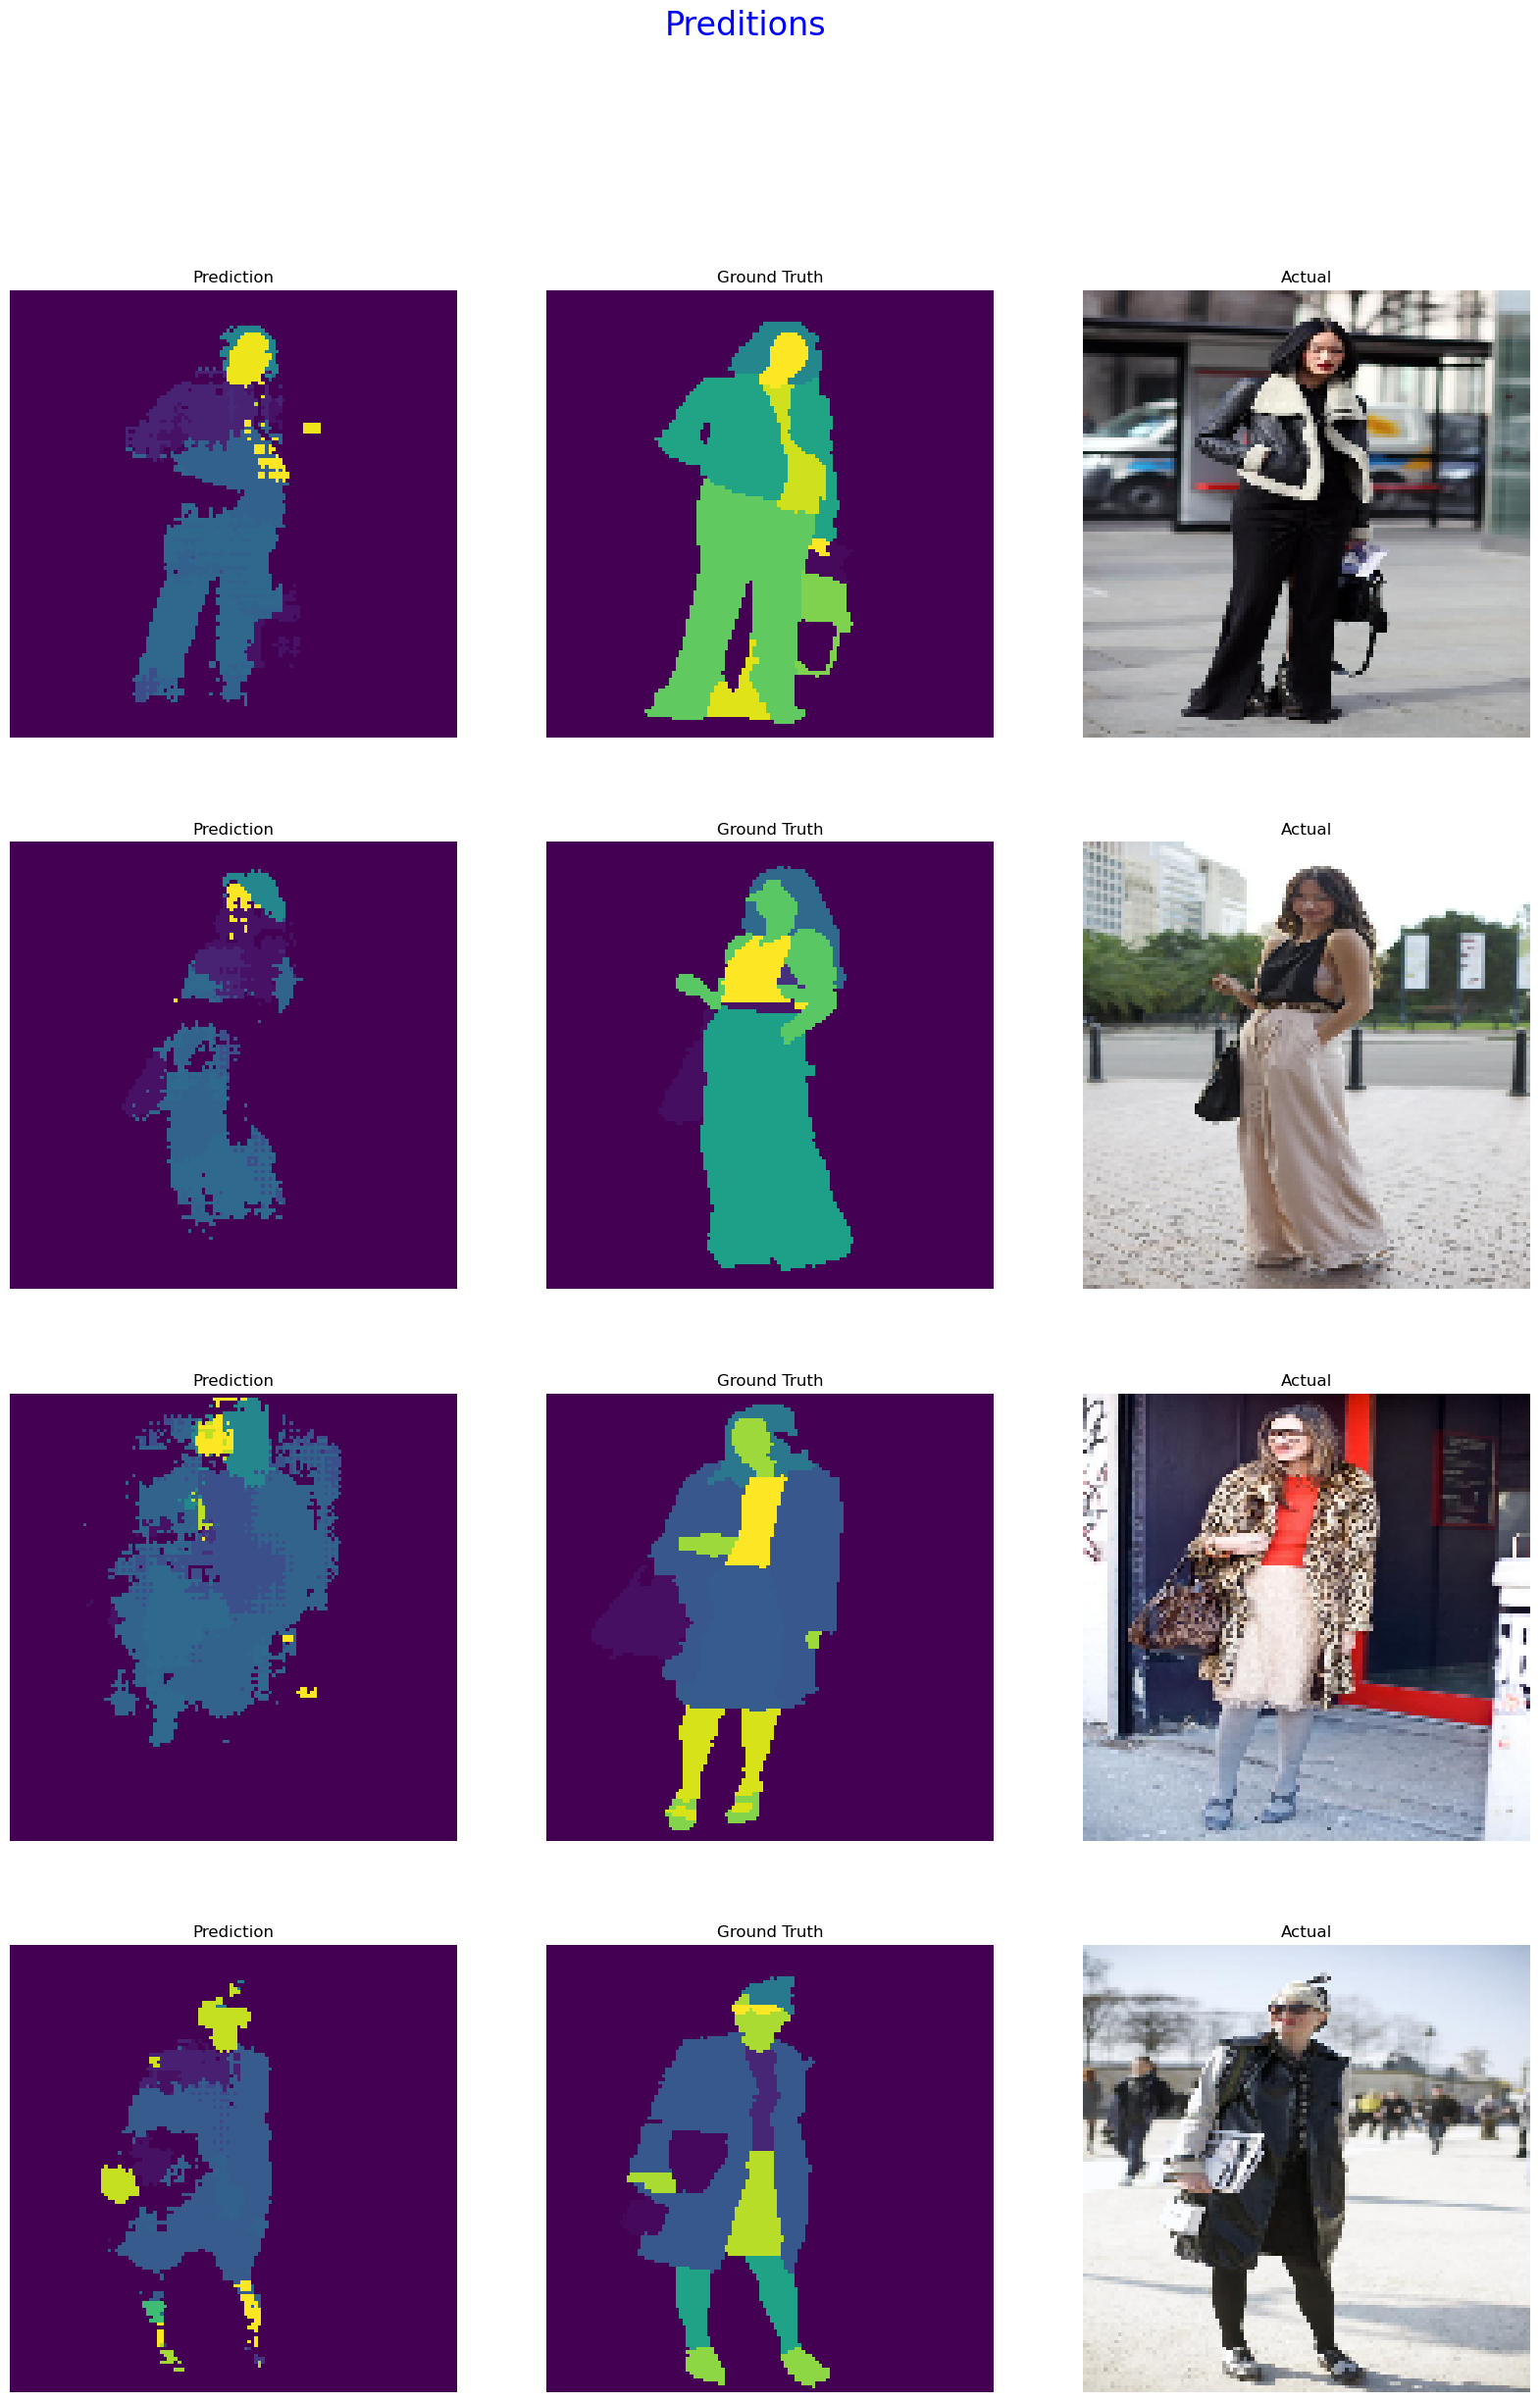

In [26]:
image, mask = next(iter(validation_dataset))
pred = unet_model.predict(image)

image_viewer.show_pred(image, mask, pred)

#### 5.8 Model Performance - Tuned Model

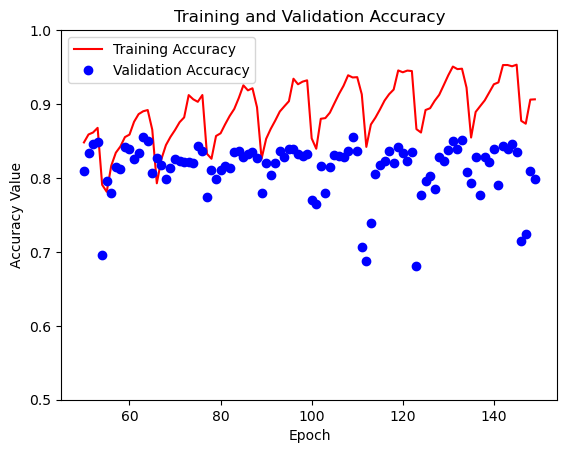

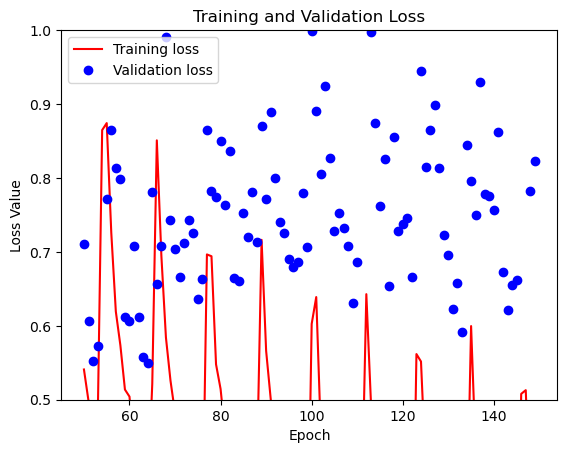

In [27]:
performance_report.plot_accuracy_performance_charts(history_1)
performance_report.plot_loss_performance_charts(history_1)

In [28]:
print("Accuracy: ", history_1.history['accuracy'][-1])
print("Loss: ", history_1.history['loss'][-1])

Accuracy:  0.9063642024993896
Loss:  0.3348081409931183


### 6. Save the U-Net Model

In [29]:
# Save the model for later use
unet_model.save('Models/segmentation_model.h5')